# FairGBM example with hyperparameter tuning (using UCI Adult dataset)

**IMPORTANT**: as FairGBM is a research project, the default hyperparameters will not be as reliable as the default `lightgbm` or `sklearn` hyperparameters.

Therefore we earnestly **recommend performing hyperparameter-tuning** on the `fairgbm` hyperparameters, most importantly on the `multiplier_learning_rate` parameter!

This notebook has extra requirements besides `fairgbm`. Simply run ```pip install -r requirements.txt``` to get them!

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
SEED = 42

### Load data

In [3]:
from utils import load_uci_adult
train_set, other_set = load_uci_adult()
train_set.head()

-1 / unknown

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


Split features (X), labels (Y), and sensitive attributes (S).

**NOTE**: the labels (Y) and sensitive attributes (S) must be in numeric format!

In [4]:
UCI_ADULT_TARGET_COL = "target"
UCI_ADULT_SENSITIVE_COL = "sex"

def split_X_Y_S_uci_adult(data) -> tuple:
    """Splits the given UCI Adult data into features, target, and sensitive attributes.
    
    Returns
    -------
    X, Y, S : tuple[pd.DataFrame, pd.Series, pd.Series]
        A tuple conmtaining the dataset's features, labels, and sensitive attributes.
    """
    ignored_cols = [UCI_ADULT_TARGET_COL, UCI_ADULT_SENSITIVE_COL, "fnlwgt"]
    feature_cols = [col for col in data.columns if col not in ignored_cols]

    X = data[feature_cols]
    
    # Convert label to numeric
    Y = np.array(
        [0 if "<=50K" in val.strip() else 1 for val in data[UCI_ADULT_TARGET_COL]],
        dtype=int)

    # Convert sensitive attributes to numeric
    # NOTE! You can use two or more sensitive groups!
    S = np.array(
        [1 if val == "Female" else 0 for val in data[UCI_ADULT_SENSITIVE_COL]],
        dtype=int)
    
    return X, Y, S

In this example we're using only two sensitive attributes (sex="Female" or sex="Male").

However, _FairGBM is **not** restricted to binary sensitive attributes_: you can use two or more as long as they're encoded in a single numeric column.

---
Split test data into validation and test (we need a validation set for hyperparameter tuning).

In [5]:
VALIDATION_SIZE_N = int(0.5 * len(other_set))

indices = np.random.permutation(len(other_set))
val_indices = indices[VALIDATION_SIZE_N: ]
test_indices = indices[: VALIDATION_SIZE_N]

val_set = other_set.iloc[val_indices]
test_set = other_set.iloc[test_indices]

In [6]:
X_train, Y_train, S_train = split_X_Y_S_uci_adult(train_set)
X_val, Y_val, S_val = split_X_Y_S_uci_adult(val_set)
X_test, Y_test, S_test = split_X_Y_S_uci_adult(test_set);

###  Define FairGBM hyperparameter search space and tuner

We're using the [`hyperparameter-tuning`](https://pypi.org/project/hyperparameter-tuning/) package (essentially contains a series of useful wrappers around `optuna`).

In [7]:
# This file contains an example hyperparameter search space for FairGBM
HYPERPARAM_SPACE_PATH = "fairgbm_equalized-odds.yaml"

This tuner configuration will maximize the average of `accuracy` and `equal_odds_ratio`.

In [8]:
from hpt.tuner import ObjectiveFunction, OptunaTuner

obj_func = ObjectiveFunction(
    X_train=X_train, y_train=Y_train, s_train=S_train,
    X_val=X_val, y_val=Y_val, s_val=S_val,
    hyperparameter_space=HYPERPARAM_SPACE_PATH,
    eval_metric="accuracy",
    other_eval_metric="equal_odds_ratio",
    threshold=0.50,
    alpha=0.50,   # how much weight to give to `other_eval_metric`
)

tuner = OptunaTuner(
    objective_function=obj_func,
    direction="maximize",
    seed=SEED,
)

[I 2023-07-14 20:47:01,877] A new study created in memory with name: no-name-a37f39e4-165d-473a-93f1-a1444c9c96d1


### Run HPT tuner

In [9]:
%%time
# Then just run optimize as you would for an optuna.Study object
tuner.optimize(n_trials=50, n_jobs=8)

[I 2023-07-14 20:47:02,491] Trial 1 finished with value: 0.6258986454217821 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'goss', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 95, 'learner_FairGBM_num_leaves': 5, 'learner_FairGBM_min_child_samples': 290, 'learner_FairGBM_max_depth': 10, 'learner_FairGBM_learning_rate': 0.03837587742291467, 'learner_FairGBM_reg_alpha': 0.0007064131278407865, 'learner_FairGBM_reg_lambda': 0.0014357255484088096, 'learner_FairGBM_constraint_type': 'FNR,FPR', 'learner_FairGBM_multiplier_learning_rate': 0.005234596781724395}. Best is trial 1 with value: 0.6258986454217821.
[I 2023-07-14 20:47:02,951] Trial 8 finished with value: 0.6493120421033222 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'gbdt', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 95, 'learner_FairGBM_num_leaves': 27, 'learner_FairGBM_min_child_samples': 100, 'learner_FairGBM_max_d

[I 2023-07-14 20:47:10,537] Trial 18 finished with value: 0.8131770250674151 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'gbdt', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 362, 'learner_FairGBM_num_leaves': 4, 'learner_FairGBM_min_child_samples': 7, 'learner_FairGBM_max_depth': 4, 'learner_FairGBM_learning_rate': 0.17752034307066794, 'learner_FairGBM_reg_alpha': 0.005256226248975853, 'learner_FairGBM_reg_lambda': 0.09529907853404387, 'learner_FairGBM_constraint_type': 'FNR,FPR', 'learner_FairGBM_multiplier_learning_rate': 0.04229192000942086}. Best is trial 18 with value: 0.8131770250674151.
[I 2023-07-14 20:47:10,681] Trial 20 finished with value: 0.6765218487787446 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'goss', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 103, 'learner_FairGBM_num_leaves': 6, 'learner_FairGBM_min_child_samples': 9, 'learner_FairGBM_max_depth'

[I 2023-07-14 20:47:15,329] Trial 31 finished with value: 0.6275080880593589 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'goss', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 61, 'learner_FairGBM_num_leaves': 30, 'learner_FairGBM_min_child_samples': 52, 'learner_FairGBM_max_depth': 7, 'learner_FairGBM_learning_rate': 0.3232729648853259, 'learner_FairGBM_reg_alpha': 0.0002064381008123776, 'learner_FairGBM_reg_lambda': 0.006903256881059685, 'learner_FairGBM_constraint_type': 'FNR,FPR', 'learner_FairGBM_multiplier_learning_rate': 0.027723803425911662}. Best is trial 12 with value: 0.845103625700087.
[I 2023-07-14 20:47:15,531] Trial 30 finished with value: 0.6795878558779631 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'gbdt', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 153, 'learner_FairGBM_num_leaves': 4, 'learner_FairGBM_min_child_samples': 139, 'learner_FairGBM_max_de

[I 2023-07-14 20:47:18,243] Trial 45 finished with value: 0.6680398424525561 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'gbdt', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 121, 'learner_FairGBM_num_leaves': 6, 'learner_FairGBM_min_child_samples': 20, 'learner_FairGBM_max_depth': 6, 'learner_FairGBM_learning_rate': 0.040507866776548045, 'learner_FairGBM_reg_alpha': 0.0035436168677511343, 'learner_FairGBM_reg_lambda': 0.00015572619152512214, 'learner_FairGBM_constraint_type': 'FNR,FPR', 'learner_FairGBM_multiplier_learning_rate': 0.09996793961185357}. Best is trial 6 with value: 0.8473399207225254.
[I 2023-07-14 20:47:19,593] Trial 22 finished with value: 0.7999263038510098 and parameters: {'learner_type': 'FairGBM', 'learner_FairGBM_boosting_type': 'goss', 'learner_FairGBM_enable_bundle': False, 'learner_FairGBM_n_estimators': 1609, 'learner_FairGBM_num_leaves': 5, 'learner_FairGBM_min_child_samples': 26, 'learner_FairGBM_max

CPU times: user 3min 7s, sys: 347 ms, total: 3min 7s
Wall time: 29.3 s


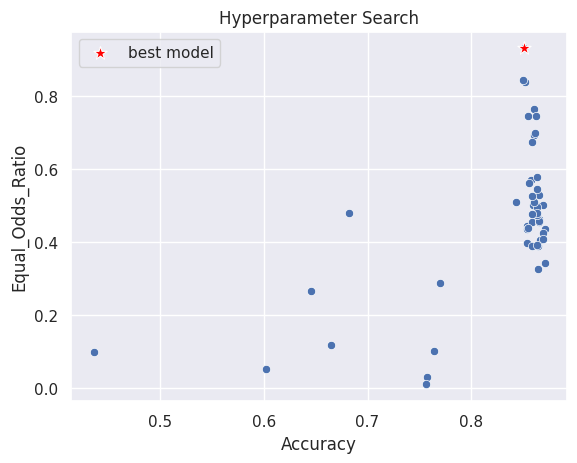

In [10]:
tuner.objective_function.plot()

Hyperparameter tuning (HPT) results are stored in `tuner.results`:

In [11]:
# Show results with best fairness
tuner.results.sort_values(by="equal_odds_ratio", ascending=False).head()

,algorithm,accuracy,tpr,fnr,fpr,tnr,precision,ppr,squared_loss,log_loss,...,tpr_ratio,tpr_diff,precision_ratio,precision_diff,tnr_ratio,tnr_diff,fnr_ratio,fnr_diff,equal_odds_ratio,equal_odds_diff
44,FairGBMClassifier,0.851124,0.540458,0.459542,0.050032,0.949968,0.774617,0.168407,0.104920,0.329557,...,0.930690,0.039758,0.743810,0.210485,0.998586,0.001345,0.914709,0.039758,0.930690,0.039758
6,FairGBMClassifier,0.850018,0.631552,0.368448,0.080473,0.919527,0.714039,0.213487,0.106740,0.391564,...,0.860485,0.099715,0.753506,0.186816,0.985652,0.013310,0.740994,0.099715,0.844661,0.099715
12,FairGBMClassifier,0.851861,0.642239,0.357761,0.081444,0.918556,0.715014,0.216804,0.104590,0.391621,...,0.838346,0.120001,0.732085,0.205006,0.994887,0.004712,0.682260,0.120001,0.838346,0.120001
18,FairGBMClassifier,0.860582,0.592366,0.407634,0.054080,0.945920,0.777036,0.184007,0.096303,0.299928,...,0.765772,0.172438,0.772331,0.187659,0.995529,0.004237,0.604719,0.172438,0.765772,0.172438
41,FairGBMClassifier,0.862302,0.616285,0.383715,0.059424,0.940576,0.767427,0.193834,0.097406,0.306963,...,0.931944,0.044466,0.800994,0.159397,0.982353,0.016778,0.886302,0.044466,0.745754,0.044466


### Reconstruct classifier from best HPT trial

In our case, the best trial is trial 21!

In [12]:
print(f"Best trial was #{obj_func.best_trial.id}.")

Best trial was #44.


In [13]:
%%time
fairgbm_clf = obj_func.reconstruct_model(obj_func.best_trial)

CPU times: user 5.95 s, sys: 155 µs, total: 5.95 s
Wall time: 5.96 s


### Compute binary predictions
Note that the sensitive attributes are only used in training and not for predicting!

In [14]:
# Compute test predictions (select only probabilities for positive class)
Y_test_pred = fairgbm_clf.predict_proba(X_test)[:, 1]

### And evaluate test performance and fairness

In [15]:
from hpt.evaluation import evaluate_predictions

test_eval = evaluate_predictions(
    y_true=Y_test, y_pred_scores=Y_test_pred,
    sensitive_attribute=S_test,
    threshold=0.50,
)

test_eval

{'accuracy': 0.8555282555282555,
 'tpr': 0.5587453482190324,
 'fnr': 0.44125465178096757,
 'fpr': 0.055280396229429624,
 'tnr': 0.9447196037705704,
 'precision': 0.7523264137437365,
 'ppr': 0.17162162162162162,
 'squared_loss': 0.10316048595549515,
 'log_loss': 0.3265886465823243,
 'accuracy_ratio': 0.9230303312818893,
 'accuracy_diff': 0.06943658944872522,
 'ppr_ratio': 0.5392664510992754,
 'ppr_diff': 0.09319248975568382,
 'fpr_ratio': 0.8697132712894723,
 'fpr_diff': 0.007829082330305229,
 'tpr_ratio': 0.9959900442477876,
 'tpr_diff': 0.00224180581323441,
 'precision_ratio': 0.6153586798399806,
 'precision_diff': 0.3146748899770656,
 'tnr_ratio': 0.9917391904959247,
 'tnr_diff': 0.007829082330305326,
 'fnr_ratio': 0.9949415663701379,
 'fnr_diff': 0.0022418058132343543,
 'equal_odds_ratio': 0.8697132712894723,
 'equal_odds_diff': 0.007829082330305229}

In [16]:
print(f"FairGBM results:")
print(f"\t Accuracy : {test_eval['accuracy']:.1%}")
print(f"\t Equalized odds ratio (higher is better): {test_eval['equal_odds_ratio']:.1%}")
print(f"\t Equalized odds difference (lower is better): {test_eval['equal_odds_diff']:.1%}")

FairGBM results:
	 Accuracy : 85.6%
	 Equalized odds ratio (higher is better): 87.0%
	 Equalized odds difference (lower is better): 0.8%
